# **OPLS-DA pipeline**


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import cross_validation
import plotting
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import permutation_test_score
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.filterwarnings('ignore')

from pyChemometrics import ChemometricsScaler



In [2]:
df_path = '/Users/aeiwz/Library/CloudStorage/OneDrive-KhonKaenUniversity/KKUPC/Project/Alpha/KKUPC6602013/Re-analyse/Raw data/Dataset'

df = pd.read_csv('{}/KKUPC6602013_dataset.csv'.format(df_path))

In [3]:
df['Intervention'].unique()

array(['Diazepam', '0.5% SCMC', 'TKM powder 600 mg/kg', 'Imipramine',
       'Vitamin E', 'TKM powder 37.5 mg/kg', 'TKM powder 150 mg/kg',
       'UCMS', nan], dtype=object)

In [4]:
#Drop row are contain QC in Group column
df = df[df['Group'] != 'QC']

In [5]:
test_select = pd.concat([df.loc[df['Intervention'] == df['Intervention'].unique()[1]], df.loc[df['Intervention'] == df['Intervention'].unique()[2]]], axis=0)

In [6]:
spectra = test_select.iloc[:, 28:]
ppm = list(spectra.columns.astype(float))
X = spectra.values
y = test_select['Intervention'].values

In [84]:
# Create a pipeline with data preprocessing and OPLS-DA model
pipeline = Pipeline([
    ('scale', ChemometricsScaler(scale_power=0.5)),
    ('oplsda', PLSRegression(n_components=2)),
    ('opls', cross_validation.CrossValidation(kfold=3, estimator='opls', scaler='pareto'))
])

In [85]:
oplsda = pipeline.named_steps['oplsda']

In [86]:
oplsda.fit(X, pd.Categorical(y).codes)

PLSRegression()

In [110]:
cv = pipeline.named_steps['opls']

In [88]:
cv.fit(X, y)

In [113]:
cv.optimal_component_num

3

In [144]:
n_permutate = 1000

# Permutation test to assess the significance of the model
acc_score, permutation_scores, p_value = permutation_test_score(
    estimator=pipeline.named_steps['oplsda'], 
    X=X, 
    y=pd.Categorical(y).codes, 
    cv=3, 
    n_permutations=n_permutate, 
    n_jobs=-1, 
    verbose=10, 
    random_state=57)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05356431007385254s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1397080421447754s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19800505439717359s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    1.2s
[Parallel(n_jobs=

In [145]:
print('Accuracy score: {}, \np-value: {}'.format(acc_score, p_value))

Accuracy score: 0.05637365450380549, 
p-value: 0.03196803196803197


In [93]:
plot = plotting.Plots(cv)

In [106]:
cv.reset_optimal_num_component(2)

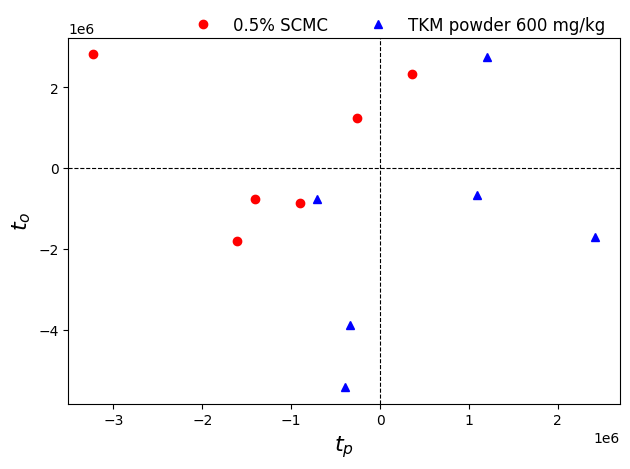

In [146]:
plot.plot_scores()

In [ ]:
permutation_test_score()

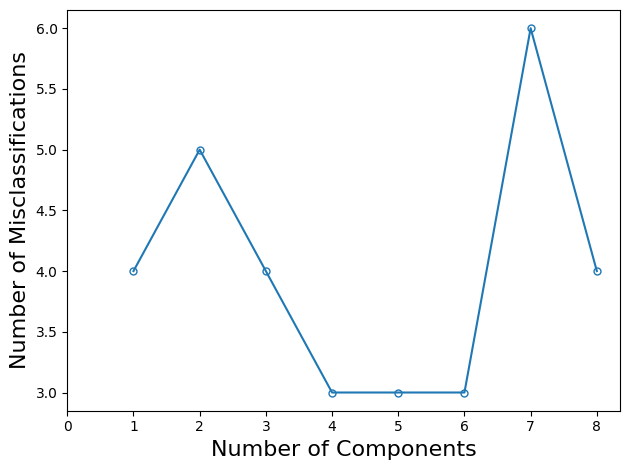

In [35]:
plot.plot_cv_errors()

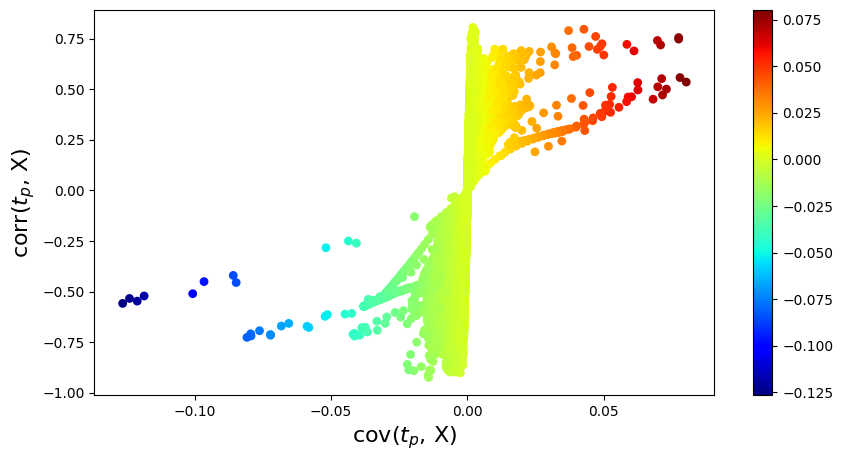

In [105]:
plot.splot()

In [37]:
s_scores_df = pd.DataFrame({'correlation': cv.correlation,'covariance': cv.covariance}, index=ppm)

In [38]:
# sub-plot covariance for x and correlation for y S-plot using plotly, color by covariance with jet colormap
#setup figure size


fig = px.scatter(s_scores_df, x='covariance', y='correlation', color='covariance', color_continuous_scale='jet', text=s_scores_df.index, height=900, width=2000)
fig.update_layout(title='<b>S-plot</b>', xaxis_title='Covariance', yaxis_title='Correlation')





#add line of axis and set color to black and line width to 2 pixel
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
#Add tick width to 2 pixel
fig.update_xaxes(tickwidth=2)
fig.update_yaxes(tickwidth=2)
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
#Set font size to 20
#Set marker size to 5 pixel
fig.update_traces(marker=dict(size=8))
fig.show()



In [39]:

fig = px.scatter(s_scores_df, x=ppm, y=np.median(X, axis=0), color='covariance', color_continuous_scale='jet', text=s_scores_df.index, height=500, width=2000)

fig.update_traces(marker=dict(size=3))
fig.update_xaxes(autorange="reversed")
fig.update_layout(title='<b>Median spectra</b>', xaxis_title='ppm', yaxis_title='Intensity (AU)')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
#Add tick width to 2 pixel
fig.update_xaxes(tickwidth=2)
fig.update_yaxes(tickwidth=2)

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
#Set marker size to 5 pixel
fig.update_traces(marker=dict(size=3))
fig.show()



In [40]:
#Loadings plot
#apply dataset of median spectra to loadings plot 
corr_convert = np.where(s_scores_df['correlation'].values < 0, -1, 1)
med_apply = np.multiply(np.median(X, axis=0), corr_convert)
fig = px.scatter(s_scores_df, x=ppm, y=med_apply, color='covariance', color_continuous_scale='jet', text=s_scores_df.index, height=500, width=2000)

fig.update_traces(marker=dict(size=3))
fig.update_xaxes(autorange="reversed")
fig.update_layout(title='<b>Median spectra</b>', xaxis_title='ppm', yaxis_title='Intensity (AU)')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
#Add tick width to 2 pixel
fig.update_xaxes(tickwidth=2)
fig.update_yaxes(tickwidth=2)

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
#Set marker size to 5 pixel
fig.update_traces(marker=dict(size=3))
fig.show()


In [80]:
cv.reset_optimal_num_component(7)

In [81]:
cv.q2, cv.R2y, cv.R2Xcorr

(-9.648301430520256e+24, 0.9999654018655684, 1.597933182769529)

In [82]:
df_opls_scores = pd.DataFrame({'t_scores': cv.scores, 't_ortho': cv.orthogonal_score, 't_pred': cv.predictive_score, 'label': y})

In [83]:
from pca_ellipse import confidence_ellipse
fig = px.scatter(df_opls_scores, x='t_pred', y='t_ortho', 
                 color='label', 
                 color_discrete_map={
                                    "UCMS": "#E91E63",        
                                    "TKM powder 150 mg/kg": "#FF9800",
                                    "Imipramine": "#FFEB3B",       
                                    "TKM powder 37.5 mg/kg": "#9C27B0",
                                    "Vitamin E": "#03A9F4",
                                    "Diazepam": "#4CAF50",        
                                    "TKM powder 600 mg/kg": "#B30000",
                                    "0.5% SCMC": "#3F51B5",
                                    "No class of prediction": "#000000"
                                    }, 
                title='<b>OPLS-DA Scores Plot<b>', 
                height=900, width=1300,
                labels={
                    't_pred': 't<sub>predict</sub>',
                    't_ortho': 't<sub>orthogonal</sub>',
                    'label': 'Intervention'}
                )

#fig.add_annotation(yref = 'paper', y = -1.06, xref = 'paper', x=1.06 , text='Q2' +' = {}'.format(np.round(df_explained_variance_.iloc[2,2], decimals=2)))
#fig.update_annotations(font = {
#    'size': 20}, showarrow=False)

#set data point fill alpha with boarder in each color
fig.update_traces(marker=dict(size=35, opacity=0.7, line=dict(width=2, color='DarkSlateGrey')))

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.04+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>X: {}%<b>'.format(np.round(cv.R2Xcorr*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.0+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>Y: {}%<b>'.format(np.round(cv.R2y*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")
fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.08+0.05,
                        showarrow=False,
                        text='<b>Q<sup>2</sup>: {}%<b>'.format(np.round(cv.q2*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_shape(type='path',
        path=confidence_ellipse(df_opls_scores['t_pred'], df_opls_scores['t_ortho']))


fig.update_traces(marker=dict(size=35))
#fig.update_traces(textposition='top center') #Text label position
#change M to 10^6
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")

#fig.update_traces(marker=dict(size=12, color=Y1_color, marker=Y2_marker))

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')

fig.show()
#fig.write_image("{}/Scores_plot/PNG_scores/{}.png".format(path_, name[i]))
#fig.write_html("{}/Scores_plot/HTML_scores/{}.html".format(path_, name[i]))



In [ ]:
oplsda.x_scores_.shape

In [47]:
#Plot histogram of permutation scores
fig = px.histogram(permutation_scores, nbins=50, height=500, width=1000, 
                   title='<b>Permutation scores<b>',
                   labels={'value': 'Accuracy score', 
                           'count': 'Frequency'})
#add dashed line to indicate the accuracy score of the model line y location is maximum count of histogram
fig.add_shape(type='line', yref='paper', y0=0, y1=1, xref='x', x0=acc_score, x1=acc_score, line=dict(dash='dash', color='red', width=3))


fig.add_annotation(dict(font=dict(color="black",size=14),
                        #x=x_loc,
                        x=0,
                        y=1.25,
                        showarrow=False,
                        text='Number of permutation: {}'.format(n_permutate),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_annotation(dict(font=dict(color="black",size=14),
                        #x=x_loc,
                        x=0,
                        y=1.18,
                        showarrow=False,
                        text='Accuracy score: {}'.format(np.round(acc_score, decimals=3)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")
fig.add_annotation(dict(font=dict(color="black",size=14),
                        #x=x_loc,
                        x=0,
                        y=1.11,
                        showarrow=False,
                        text='<i>p-value</i>: {}'.format(np.round(p_value, decimals=6)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.update_layout(showlegend=False)

fig.update_layout(title_x=0.5)

fig.show()




In [54]:
cv.reset_optimal_num_component(1)

In [ ]:
cv.predict(X)

In [ ]:
cv.orthogonal_score

In [ ]:
cross_validation

In [ ]:
oplsda.x_scores_

In [ ]:
df_opls_scores = pd.DataFrame({'t_scores': oplsda.x_scores_.T[0], 't_ortho': cv.orthogonal_score, 't_pred': cv.predictive_score, 'label': y})

In [ ]:
df_opls_scores

In [ ]:
x=oplsda.x_scores_.T[0]

In [ ]:
oplsda.coef_, oplsda.scale

In [ ]:
from pca_ellipse import confidence_ellipse
fig = px.scatter(df_opls_scores, x=oplsda.x_scores_.T[0], y='t_ortho', 
                 color='label', 
                 color_discrete_map={
                                    "UCMS": "#E91E63",        
                                    "TKM powder 150 mg/kg": "#FF9800",
                                    "Imipramine": "#FFEB3B",       
                                    "TKM powder 37.5 mg/kg": "#9C27B0",
                                    "Vitamin E": "#03A9F4",
                                    "Diazepam": "#4CAF50",        
                                    "TKM powder 600 mg/kg": "#B30000",
                                    "0.5% SCMC": "#3F51B5",
                                    "No class of prediction": "#000000"
                                    }, 
                title='<b>OPLS-DA Scores Plot<b>', 
                height=900, width=1300,
                labels={
                    't_pred': 't<sub>predict</sub>',
                    't_ortho': 't<sub>orthogonal</sub>',
                    'label': 'Intervention'}
                )

#fig.add_annotation(yref = 'paper', y = -1.06, xref = 'paper', x=1.06 , text='Q2' +' = {}'.format(np.round(df_explained_variance_.iloc[2,2], decimals=2)))
#fig.update_annotations(font = {
#    'size': 20}, showarrow=False)

#set data point fill alpha with boarder in each color
fig.update_traces(marker=dict(size=35, opacity=0.7, line=dict(width=2, color='DarkSlateGrey')))

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.04+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>X: {}%<b>'.format(np.round(cv.R2X*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.0+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>Y: {}%<b>'.format(np.round(cv.R2y*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")
fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.08+0.05,
                        showarrow=False,
                        text='<b>Q<sup>2</sup>: {}%<b>'.format(np.round(cv.q2*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

'''fig.add_shape(type='path',
        path=confidence_ellipse(df_opls_scores['t_pred'], df_opls_scores['t_ortho']))
'''

fig.update_traces(marker=dict(size=35))
#fig.update_traces(textposition='top center') #Text label position
#change M to 10^6
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")

#fig.update_traces(marker=dict(size=12, color=Y1_color, marker=Y2_marker))

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')

fig.show()
#fig.write_image("{}/Scores_plot/PNG_scores/{}.png".format(path_, name[i]))
#fig.write_html("{}/Scores_plot/HTML_scores/{}.html".format(path_, name[i]))



In [ ]:
y_ = pd.Categorical(y).codes
y_ = np.where(y_ == 0, -1, y_)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score




opls = OPLS(3)
Z = opls.fit_transform(spectra, y_)

pls = PLSRegression(1)
y_pred = cross_val_predict(pls, X, y_, cv=LeaveOneOut())
q_squared = r2_score(y_, y_pred)  # -0.107
dq_squared = r2_score(y_, np.clip(y_pred, -1, 1))  # -0.106
accuracy = accuracy_score(y_, np.sign(y_pred))  # 0.705

processed_y_pred = cross_val_predict(pls, Z, y_, cv=LeaveOneOut())
processed_q_squared = r2_score(y_, processed_y_pred)  # 0.981
processed_dq_squared = r2_score(y_, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y_, np.sign(processed_y_pred))  # 1.0

r2_X = opls.score(spectra)  # 7.8e-12 (most variance is removed)

fpr, tpr, thresholds = roc_curve(y_, y_pred)
roc_auc = roc_auc_score(y_, y_pred)
proc_fpr, proc_tpr, proc_thresholds = roc_curve(y_, processed_y_pred)
proc_roc_auc = roc_auc_score(y_, processed_y_pred)

plt.figure(0)
plt.plot(fpr, tpr, lw=2, color='blue', label=f'Unprocessed (AUC={roc_auc:.4f})')
plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'39-component OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(1)
pls.fit(Z, y_)
df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:, 0]]),
                  index=spectra.index, columns=['t', 't_ortho'])                           
pos_df = df[y_==1]
neg_df = df[y_==-1]
plt.scatter(neg_df['t'], neg_df['t_ortho'], c='blue', label='Healthy Control')
plt.scatter(pos_df['t'], pos_df['t_ortho'], c='red', label='Colorectal Cancer')
plt.title('PLS Scores')
plt.xlabel('t_ortho')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()

In [ ]:
opls.T_ortho_

In [ ]:
X